#### Задание
В данном задании вам нужно будет провести анализ данных проведенного A/B-теста.

Данные будут предоставлены в формате csv. Они будут содержать также часть пред экспериментального этапа.

Описание эксперимента:
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле.

Метрика: средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

Важная информация:
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

Описание данных:
id_product -  идентификатор продукта, который был рекомендован
is_pay - купил ли пользователь товар
sum_payment - размер платежа (0, если не купил)
city - город, в котором находится пользователь
id_user - пользователь
timestamp - timestamp события
date - дата события

Задачи, которые необходимо решить:
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.
Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.
Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать.

Дополнительно:
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("/Users/sofia/Downloads/ab_made_4.gzip")

In [4]:
data

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01
...,...,...,...,...,...,...,...,...
56400,1685485266,user_10740,0,A,Санкт-Петербург,14.0,0,2023-05-31
56401,1685481632,user_3589,0,B,Санкт-Петербург,1.0,0,2023-05-31
56402,1685514383,user_10664,13,A,Москва,17.0,1,2023-05-31
56403,1685481325,user_3537,0,B,Ярославь,19.0,0,2023-05-31


In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s') + timedelta(hours=3)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [6]:
print('Number of records with sum_payment = 0: ', len(data[data.sum_payment == 0]))
print('Number of records with sum_payment != 0: ', len(data[data.sum_payment != 0]))

Number of records with sum_payment = 0:  40621
Number of records with sum_payment != 0:  15784


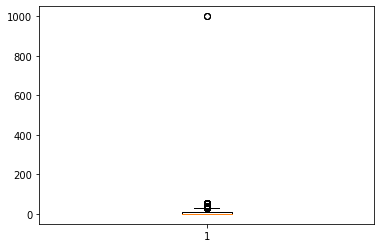

In [7]:
fig, ax = plt.subplots()
ax.boxplot(data['sum_payment'])
plt.show()

в данных очень много записей с sum_payment = 0, а значит при рассчете квантией будет перекос к этому значению, но выбросы тоже есть, удалим слишком большие суммы платежа

In [8]:
data = data[data.sum_payment <= data.sum_payment.quantile(q=0.99)]

In [9]:
pre_group = data[data['group'].isna()]
group_A = data[data['group'] == 'A']
group_B = data[data['group'] == 'B']

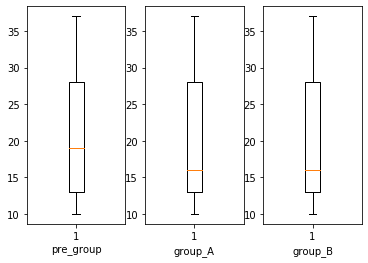

In [10]:
groups = ['pre_group', 'group_A', 'group_B']
dfs = [pre_group, group_A, group_B]
fig, ax = plt.subplots(1, 3)
ax = ax.flat
for num, df in enumerate(dfs):
    ax[num].boxplot(df[df.sum_payment != 0]['sum_payment'])
    ax[num].set_xlabel(groups[num])
plt.show()

если посмотреть  на группы без нулевых платежей то выглядит хорошо, не будем удалять что-либо еще

In [11]:
for df, name in zip(dfs, groups):
    print(f'Number of unique users in {name}:', df.id_user.nunique())

for df, name in zip(dfs, groups):
    print(f'For group {name} min date: {df.timestamp.min()} and max date: {df.timestamp.max()}')


Number of unique users in pre_group: 9968
Number of unique users in group_A: 5976
Number of unique users in group_B: 5975
For group pre_group min date: 2023-04-01 03:40:17 and max date: 2023-04-30 23:59:46
For group group_A min date: 2023-05-01 08:48:05 and max date: 2023-05-31 23:59:57
For group group_B min date: 2023-05-01 01:43:46 and max date: 2023-05-31 23:58:59


In [12]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

def get_power(p_values, alpha=0.05):
    """Оценка мощности критерия, при условии, что значения p_value взяты при наличии
    различий в сравниваемых выборках
    """
    p_values = np.array(p_values)
    return p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100

def filter_df_by_week(df):
    user_start_window_dt = df.groupby('id_user')['timestamp'].min()
    user_end_window_dt = user_start_window_dt + timedelta(weeks=1)
    df[df.apply(lambda x: user_start_window_dt[x.id_user] <= x.timestamp <= user_end_window_dt[x.id_user], axis=1)]
    return df

def calculate_week_payments(df):
    df = filter_df_by_week(df)
    df_total_sum_grouped = df.groupby('id_user')['sum_payment'].sum().tolist()
    return df_total_sum_grouped



In [13]:
alpha = 0.05
power = 0.8
beta = 1 - power
effect = 10
k = 1
week_paymants_pre_group = calculate_week_payments(pre_group)
sigma = np.std(week_paymants_pre_group)
mu = np.mean(week_paymants_pre_group)
effect = mu * effect / 100
duration_ = int(duration(k, effect, sigma, sigma, alpha, beta))
duration_group = duration_ // 2
print(f"Оценка длительности: {duration_group}")

Оценка длительности: 3262


In [14]:
def ab_test(df_a, df_b):
    start_date = max(df_a.timestamp.min(), df_b.timestamp.min()).date() + timedelta(weeks=1)
    end_date = min(df_a.timestamp.max(), df_b.timestamp.max()).date()

    dates_range = pd.date_range(start_date, end_date)
    data = []

    for date in dates_range:
        date_lim = date - timedelta(weeks=1)
        df_a_slice = df_a[(date >= df_a.timestamp) & (df_a.timestamp > date_lim)]
        df_b_slice = df_b[(date >= df_b.timestamp) & (df_b.timestamp > date_lim)]

        week_payments_a = calculate_week_payments(df_a_slice)
        week_payments_b = calculate_week_payments(df_b_slice)

        mean_week_payment_a = np.mean(week_payments_a)
        mean_week_payment_b = np.mean(week_payments_b)

        mean_week_payments_effect = mean_week_payment_b - mean_week_payment_a

        ttest = sps.ttest_ind(week_payments_a, week_payments_b)
        statistic, p_value = ttest.statistic, ttest.pvalue

        data.append({'date': date.date(),
                     'mean_week_payment_a': mean_week_payment_a,
                     'mean_week_payment_b': mean_week_payment_b,
                     'mean_week_payments_effect':mean_week_payments_effect,
                     't-statistic': statistic,
                     'p-value': p_value})

    result = pd.DataFrame(data)

    return result


In [15]:
payments = ab_test(group_A, group_B)
payments

,date,mean_week_payment_a,mean_week_payment_b,mean_week_payments_effect,t-statistic,p-value
0,2023-05-08,7.133333,8.369697,1.236364,-1.285473,0.199079
1,2023-05-09,6.837104,8.753488,1.916384,-2.234175,0.025725
2,2023-05-10,7.235185,8.673664,1.438479,-1.838376,0.066286
3,2023-05-11,7.447077,8.898714,1.451636,-1.936675,0.053010
4,2023-05-12,7.292943,8.667582,1.374640,-2.009153,0.044703
5,2023-05-13,7.105386,8.585542,1.480156,-2.353328,0.018721
6,2023-05-14,7.361345,8.419558,1.058214,-1.807171,0.070894
7,2023-05-15,7.403575,8.194471,0.790896,-1.407860,0.159320
8,2023-05-16,7.457759,8.249150,0.791391,-1.517484,0.129280
9,2023-05-17,7.695827,8.239403,0.543577,-1.056561,0.290813


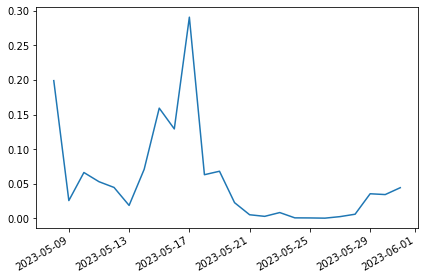

In [16]:
fig, ax = plt.subplots()
ax.plot(payments.date.values, payments['p-value'].values)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [17]:
print('Гипотеза о том, что решение с рекомендациями для группы В эффективнее', 'принимается' if payments.tail(1)['p-value'].values[0] <= 0.05 else 'отвергается')

Гипотеза о том, что решение с рекомендациями для группы В эффективнее принимается
